In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
! pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error,
    auc,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

In [ ]:
import yfinance as yf

xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers="XMR-USD", period="max", interval="1d")

# btc = yf.Ticker("BTC-USD")
# df_btc = yf.download(tickers="BTC-USD", period="max", interval="1d")

In [ ]:
df_xmr

In [ ]:
df_xmr.shift(-1)

# Make Label


In [ ]:
df_xmr["Close_difference"] = df_xmr["Close"].shift(-1) - df_xmr["Close"]
df = df_xmr.copy()

##### method1


In [ ]:
df["Label"] = (df["Close_difference"] > 0).astype(int)
df.drop("Close_difference", axis=1, inplace=True)
df

##### method2


In [ ]:
# def make_target(row):
#     diff = row["Close_difference"]
#     n = 1
#     if diff >= n:
#         return 1
#     if diff <= -n:
#         return -1
#     return 0


# df["Label"] = df.apply(make_target, axis=1)
# df.drop("Close_difference", axis=1, inplace=True)
# df

In [ ]:
df = df.reset_index(drop=False)
df

### Change Features


In [ ]:
df["Variance"] = df["High"] - df["Low"]
df

In [ ]:
df.drop(columns=["Open", "High", "Low", "Adj Close"], inplace=True)
df

# Divide Our Data


In [ ]:
# def train_test_split_by_date(
#     df: pd.DataFrame,
#     start_date_train: str,
#     end_date_train: str,
#     start_date_test: str,
#     end_date_test: str,
#     divide_X_y: bool = True,
# ):
#     df_train = df[
#         (df["Date"] >= start_date_train) & (df["Date"] <= end_date_train)
#     ].reset_index(drop=True)

#     df_test = df[
#         (df["Date"] >= start_date_test) & (df["Date"] <= end_date_test)
#     ].reset_index(drop=True)

#     if divide_X_y:
#         X_train = df_train.drop(columns=["Label"])
#         y_train = df_train["Label"]

#         X_test = df_test.drop(columns=["Label"])
#         y_test = df_test["Label"]
#         return X_train, X_test, y_train, y_test

#     return df_train, df_test

In [ ]:
def train_test_split_by_date(
    df: pd.DataFrame,
    start_date_train: str,
    end_date_train: str,
    start_date_test: str,
    end_date_test: str,
    divide_X_y: bool = True,
    test: bool = True,
):
    df_train = df[
        (df["Date"] >= start_date_train) & (df["Date"] <= end_date_train)
    ].reset_index(drop=True)

    df_test = df[
        (df["Date"] >= start_date_test) & (df["Date"] <= end_date_test)
    ].reset_index(drop=True)

    if divide_X_y:
        X_train = df_train.drop(columns=["Label"])
        y_train = df_train["Label"]
        if test:
            X_test = df_test.drop(columns=["Label"])
            y_test = df_test["Label"]
            return X_train, X_test, y_train, y_test
        return X_train, y_train

    return df_train, df_test

In [ ]:
start_date_train_test = "2017-11-09"
end_date_train_test = "2023-10-07"

df_train_test = df[
    (df["Date"] >= start_date_train_test) & (df["Date"] <= end_date_train_test)
].reset_index(drop=True)
df_train_test

# Divide Test Data


In [ ]:
start_date_train_val = "2017-11-09"
end_date_train_val = "2023-09-07"

start_date_test = "2023-09-08"
end_date_test = "2023-10-07"

df_train_val, df_test = train_test_split_by_date(
    df,
    start_date_train_val,
    end_date_train_val,
    start_date_test,
    end_date_test,
    divide_X_y=False,
)
df_test

# Plots


### Stock Chart Plot


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_xmr["Close"])
plt.title(f"{xmr} Stock Chart")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

### candlestick


In [ ]:
! pip install mplfinance

In [ ]:
import mplfinance as mpf

mpf.plot(df_xmr, type="candle", style="yahoo", title=f"{xmr} Candlestick Chart")

# Feature Engineering


### Check Missing Values


In [ ]:
df_train_val.isna().sum()

### Outlier


##### drop ountliers, Z-Score method


In [ ]:
def drop_outliers_zScore(data, threshold=3):
    z_scores = (data.iloc[:, :-1] - data.iloc[:, :-1].mean()) / data.iloc[:, :-1].std()
    print((np.abs(z_scores) < threshold).all(axis=1).sum())
    filtered_data = data[(np.abs(z_scores) < threshold).all(axis=1)]
    return filtered_data

In [ ]:
# drop_outliers_zScore(df_train_val)

##### drop outliers with LocalOutlierFactor


In [ ]:
from sklearn.neighbors import LocalOutlierFactor


def drop_outliers_LOF(data: pd.DataFrame):
    clf = LocalOutlierFactor(n_neighbors=10, contamination=0.05)  # 0.03, 0.05

    # Fit the data to the model
    y_pred = clf.fit_predict(data.iloc[:, :-1])

    # Identify the outliers
    outliers = np.where(y_pred == -1)

    return data.drop(outliers[0])

In [ ]:
# df_train_val.reset_index(drop=False)

In [ ]:
df_train_val.reset_index(drop=False).info()

In [ ]:
drop_outliers_LOF(df_train_val.reset_index(drop=False).drop("Date", axis=1))

# چون داده هامون سری زمانی هستن داده پرت پیدا کردن معنی نداره فکرکنم


### Split Train and Validation Data


In [ ]:
# start_date_train = "2017-11-09"
# end_date_train = "2023-08-07"

# start_date_val = "2023-08-08"
# end_date_val = "2023-09-07"

# df_train = df_train_val[
#     (df_train_val["Date"] >= start_date_train)
#     & (df_train_val["Date"] <= end_date_train)
# ].reset_index(drop=True)

# df_validation = df_train_val[
#     (df_train_val["Date"] >= start_date_val) & (df_train_val["Date"] <= end_date_val)
# ].reset_index(drop=True)

# X_train = df_train.drop(columns=["Label"])
# y_train = df_train["Label"]

# X_validation = df_validation.drop(columns=["Label"])
# y_validation = df_validation["Label"]

In [ ]:
start_date_train = "2017-11-09"
end_date_train = "2023-06-07"

start_date_val = "2023-06-08"
end_date_val = "2023-09-07"

X_train, X_validation, y_train, y_validation = train_test_split_by_date(
    df_train_val,
    start_date_train,
    end_date_train,
    start_date_val,
    end_date_val,
    divide_X_y=True,
)

In [ ]:
X_train.head()

In [ ]:
X_validation.head()

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(0))

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(1))

### Plot Distributions


In [ ]:
X_train.hist(figsize=[20, 12])
plt.show()

In [ ]:
X_train.describe()

### Normalizing


##### method 1 : Standard Scaler


In [ ]:
X_train_normalized_ss = X_train.copy()
X_validation_normalized_ss = X_validation.copy()

scaler_ss = StandardScaler()
cols = X_train.drop(columns=["Date"]).columns
X_train_normalized_ss[cols] = scaler_ss.fit_transform(X_train_normalized_ss[cols])
X_validation_normalized_ss[cols] = scaler_ss.transform(X_validation_normalized_ss[cols])

In [ ]:
X_train_normalized_ss.describe()

In [ ]:
X_train_normalized_ss.hist(figsize=[20, 12])
plt.show()

##### method 2 : Power Transform


In [ ]:
X_train_transformed = X_train.copy()
X_validation_transformed = X_validation.copy()

power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)

cols = X_train.drop(columns=["Date"]).columns

X_train_transformed[cols] = power_transformer.fit_transform(X_train_transformed[cols])
X_validation_transformed[cols] = power_transformer.transform(
    X_validation_transformed[cols]
)

In [ ]:
X_train_transformed.describe()

In [ ]:
X_train_transformed.hist(figsize=[20, 12])
plt.show()

##### method 3 : Min Max Scaler


In [ ]:
X_train_normalized_ms = X_train.copy()
X_validation_normalized_ms = X_validation.copy()

scaler_min_max = StandardScaler()
cols = X_train.drop(columns=["Date"]).columns
X_train_normalized_ms[cols] = scaler_min_max.fit_transform(X_train_normalized_ms[cols])
X_validation_normalized_ms[cols] = scaler_min_max.transform(
    X_validation_normalized_ms[cols]
)

In [ ]:
X_train_normalized_ms.describe()

In [ ]:
X_train_normalized_ms.hist(figsize=[20, 12])
plt.show()

In [ ]:
df_train_val.corr()

# Modeling and Evaluating


In [ ]:
def normalization(X_train, X_test, method):
    X_train_normalized = X_train.copy()
    X_test_normalized = X_test.copy()

    if method == "StandardScaler":
        ss = StandardScaler()
        X_train_normalized[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
        X_test_normalized[X_test.columns] = ss.transform(X_test[X_test.columns])

    if method == "MinMaxScaler":
        ms = MinMaxScaler()
        X_train_normalized[X_train.columns] = ms.fit_transform(X_train[X_train.columns])
        X_test_normalized[X_test.columns] = ms.transform(X_test[X_test.columns])

    if method == "PowerTransformer":
        pt = PowerTransformer()
        X_train_normalized[X_train.columns] = pt.fit_transform(X_train[X_train.columns])
        X_test_normalized[X_test.columns] = pt.transform(X_test[X_test.columns])

    return X_train_normalized, X_test_normalized

In [ ]:
def evaluation(y_true, y_pred, df_evaluation, df_confusion, model_name):
    # Evaluate
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    new_record_evaluation = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score,
        "MSE": mse,
    }

    df_evaluation.loc[model_name] = new_record_evaluation

    # Confusion matrix

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # tp = np.sum((y_true == 1) & (y_pred == 1))
    # tn = np.sum((y_true == 0) & (y_pred == 0))
    # fp = np.sum((y_true == 0) & (y_pred == 1))
    # fn = np.sum((y_true == 1) & (y_pred == 0))

    new_record_confusion = {
        "tp": confusion[1, 1],
        "tn": confusion[0, 0],
        "fp": confusion[0, 1],
        "fn": confusion[1, 0],
    }

    df_confusion.loc[model_name] = new_record_confusion

    print(confusion)
    print(new_record_evaluation)

    return df_evaluation, df_confusion

In [ ]:
def model_predict(
    df_train_val,
    model,
    test_item,
    normalize=False,
    start_date_train="2017-11-09",
    start_date_val="2023-08-08",
    end_date_val="2023-09-07",
):
    from datetime import date, timedelta

    test_item_date = test_item.Date.date()

    end_date_train = (test_item_date - timedelta(days=1)).strftime("%Y-%m-%d")

    X_train, y_train = train_test_split_by_date(
        df_train_val,
        start_date_train,
        end_date_train,
        start_date_val,
        end_date_val,
        divide_X_y=True,
        test=False,
    )

    X_train = X_train.drop("Date", axis=1)
    X_test = (test_item[1:].to_frame().T).astype(float)

    # Normalized
    # if normalize:
    X_train, X_test = normalization(X_train, X_test, method="PowerTransformer")

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    return y_pred

### Define Evaluation Matrixes


In [ ]:
df_confusion_val = pd.DataFrame({}, columns=["tn", "fp", "fn", "tp"])
df_evaluation_val = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MSE"]
)

### Logistic Regression


In [ ]:
def logestic_regression(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.linear_model import LogisticRegression

    model_lr = LogisticRegression(C=1, penalty="l2")
    model_name = "Logistic Regression"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_lr
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_lr = logestic_regression(
    df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val
)

In [ ]:
Xc = X_validation[y_validation == y_pred_lr]
Xf = X_validation[y_validation != y_pred_lr]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation, marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation, marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
Xc

In [ ]:
Xc.iloc[:, 0].shape

### Decision Tree


In [ ]:
def decision_tree_classifier(
    df, X_test, y_test, df_evaluation, df_confusion, max_depth
):
    from sklearn.tree import DecisionTreeClassifier

    model_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model_name = "Decision Tree"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_dt
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
max_depth = 25
y_pred_dt = decision_tree_classifier(
    df_train_val,
    X_validation,
    y_validation,
    df_evaluation_val,
    df_confusion_val,
    max_depth,
)

In [ ]:
Xc = X_validation[y_validation == y_pred_dt]
Xf = X_validation[y_validation != y_pred_dt]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_dt], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_dt], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
Xc

### SVM


In [ ]:
def svm(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.svm import SVC

    model_svm = SVC()
    model_name = "SVM"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    # change Label 0 to -1
    # df["Label"] = df["Label"].replace({0: -1})
    # y_test = y_test.replace({0: -1})

    model_new = model_svm
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )
    # print(y_pred_list)
    # print(y_test.tolist())

In [ ]:
y_pred_svm = svm(
    df_train_val.copy(), X_validation, y_validation, df_evaluation_val, df_confusion_val
)

In [ ]:
Xc = X_validation[y_validation == y_pred_svm]
Xf = X_validation[y_validation != y_pred_svm]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_svm], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_svm], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### AdaBoost


In [ ]:
def ada_boost(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.ensemble import AdaBoostClassifier

    model_ada = AdaBoostClassifier(random_state=42)
    model_name = "Ada Boost"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_ada
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_ab = ada_boost(df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_ab]
Xf = X_validation[y_validation != y_pred_ab]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_ab], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_ab], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### KNN


In [ ]:
def knn(
    df, X_test, y_test, df_evaluation, df_confusion, n_neighbors, metric="manhattan"
):
    from sklearn.neighbors import KNeighborsClassifier

    model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    model_name = "KNN"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_knn
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
n_neighbors = 5
metric = "minkowski"
y_pred_knn = knn(
    df_train_val,
    X_validation,
    y_validation,
    df_evaluation_val,
    df_confusion_val,
    n_neighbors,
    metric,
)

In [ ]:
Xc = X_validation[y_validation == y_pred_knn]
Xf = X_validation[y_validation != y_pred_knn]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_knn], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_knn], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### Random Forest


In [ ]:
def random_forest_classifier(
    df, X_test, y_test, df_evaluation, df_confusion, max_depth, n_estimators
):
    from sklearn.ensemble import RandomForestClassifier

    model_rf = RandomForestClassifier(
        max_depth=max_depth,
        random_state=42,
        n_estimators=n_estimators,
    )
    model_name = "Random Forest"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_rf
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
max_depth = 10
n_estimators = 100
y_pred_rfs = random_forest_classifier(
    df_train_val,
    X_validation,
    y_validation,
    df_evaluation_val,
    df_confusion_val,
    max_depth,
    n_estimators,
)

In [ ]:
Xc = X_validation[y_validation == y_pred_rfs]
Xf = X_validation[y_validation != y_pred_rfs]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_rfs], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_rfs], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### Gausian


In [ ]:
def gaussian_nb(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.naive_bayes import GaussianNB

    model_gnb = GaussianNB()
    model_name = "Gaussian NB"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_gnb
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred = gaussian_nb(
    df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val
)

In [ ]:
Xc = X_validation[y_validation == y_pred]
Xf = X_validation[y_validation != y_pred]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### XGboost


In [ ]:
! pip install xgboost

In [ ]:
def xg_boost(df, X_test, y_test, df_evaluation, df_confusion):
    from xgboost import XGBClassifier

    model_xgb = XGBClassifier(random_state=42)
    model_name = "Xg Boost"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_xgb
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_xgb = xg_boost(df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_xgb]
Xf = X_validation[y_validation != y_pred_xgb]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_xgb], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_xgb], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### Staking Models


In [ ]:
! pip install mlxtend

In [ ]:
def stacking(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from xgboost import XGBClassifier
    from mlxtend.classifier import StackingClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC

    model_svm = SVC(probability=True)
    model_lr = LogisticRegression(C=1, penalty="l2")
    model_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
    model_xgb = XGBClassifier(objective="binary:logistic", random_state=42)
    model_knn = KNeighborsClassifier(n_neighbors=12, metric="manhattan")
    model_adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)

    stacking_model = StackingClassifier(
        classifiers=[model_rf, model_knn],
        use_probas=True,
        meta_classifier=RandomForestClassifier(n_estimators=100, random_state=42),
    )

    model_name = "Stacking ()"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = stacking_model
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_s = stacking(df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_s]
Xf = X_validation[y_validation != y_pred_s]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_s], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_s], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(0))

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(1))

In [ ]:
df_evaluation_val

In [ ]:
df_confusion_val

# Test


### Divide X, y


In [ ]:
X_test = df_test.drop(columns=["Label"])
y_test = df_test["Label"]

In [ ]:
df_confusion_test = pd.DataFrame({}, columns=["tn", "fp", "fn", "tp"])
df_evaluation_test = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MSE"]
)

In [ ]:
y_pred_lr_t = logestic_regression(
    df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test
)

In [ ]:
Xc = X_validation[y_validation == y_pred_lr_t]
Xf = X_validation[y_validation != y_pred_lr_t]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_lr_t], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_lr_t], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
max_depth = 13
decision_tree_classifier(
    df_train_test,
    X_test,
    y_test,
    df_evaluation_test,
    df_confusion_test,
    max_depth,
)

In [ ]:
svm(df_train_test.copy(), X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
ada_boost(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
n_neighbors = 5


metric = "manhattan"
knn(
    df_train_test,
    X_test,
    y_test,
    df_evaluation_test,
    df_confusion_test,
    n_neighbors,
    metric,
)

In [ ]:
max_depth = 13
n_estimators = 100
random_forest_classifier(
    df_train_test,
    X_test,
    y_test,
    df_evaluation_test,
    df_confusion_test,
    max_depth,
    n_estimators,
)

In [ ]:
gaussian_nb(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
xg_boost(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
stacking(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
df_evaluation_test

In [ ]:
df_confusion_test

In [ ]:
f1_score(y_test, y_test.shift(1).fillna(0))

In [ ]:
y_test.value_counts()

# Add Extra Features

In [ ]:
btc = yf.Ticker("BTC-USD")
df_btc = yf.download(tickers = "BTC-USD", period = "max", interval = "1d")

In [ ]:
df_btc

In [ ]:
df

In [ ]:
data = df.copy()
data

In [ ]:
# Calculate the exponential moving average
data['EMA5'] = data['Close'].ewm(span=5).mean()
data

In [ ]:
# Calculate the simple moving average
data['SMA5'] = data['Close'].rolling(5).mean()
data

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['SMA5'] = imputer.fit_transform(data[['SMA5']])
data

In [ ]:
data = data.merge(df_btc[["Close"]], on="Date", how="left").rename(columns={"Close_x": "Close", "Close_y": "Close_BTC"})
data

In [ ]:
data = data.dropna(axis=0)
data

In [ ]:
data['EMA5_BTC'] = data['Close_BTC'].ewm(span=5).mean()
data

In [ ]:
# Calculate the simple moving average
data['SMA5_BTC'] = data['Close_BTC'].rolling(5).mean()
data

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['SMA5_BTC'] = imputer.fit_transform(data[['SMA5_BTC']])
data

In [ ]:
# Download the S&P 500 data
df_sp500 = yf.download(tickers = "^GSPC", period = "max", interval = "1d")

In [ ]:
df_sp500

In [ ]:
data = data.merge(df_sp500[["Close"]], on="Date", how="left").rename(columns={"Close_x": "Close", "Close_y": "Close_SP500"})
data

In [ ]:
data.isna().sum()/len(data)*100

In [ ]:
data.corr()

In [ ]:
data['Close_SP500'].mean()

In [ ]:
data = data.sort_values(['Date'])
# Cloud Coverage - interpolate
data['Close_SP500'] = data.groupby('Date')['Close_SP500'].apply(lambda x: x.interpolate(method='linear'))

In [ ]:
data

In [ ]:
data.isna().sum()/len(data)*100

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['Close_SP500'] = imputer.fit_transform(data[['Close_SP500']])

In [ ]:
data

In [ ]:
# Download the gold data
df_gold = yf.download(tickers = "GC=F", period = "max", interval = "1d")
df_gold

In [ ]:
data = data.merge(df_gold[["Close"]], on="Date", how="left").rename(columns={"Close_x": "Close", "Close_y": "Close_gold"})
data

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['Close_gold'] = imputer.fit_transform(data[['Close_gold']])
data

In [ ]:
data.corr()

In [ ]:
def train_test_split_by_date(
    df: pd.DataFrame,
    start_date_train: str,
    end_date_train: str,
    start_date_test: str,
    end_date_test: str,
    divide_X_y: bool = True,
    test: bool = True,
):
    data_train = data[
        (data["Date"] >= start_date_train) & (data["Date"] <= end_date_train)
    ].reset_index(drop=True)

    data_test = data[
        (data["Date"] >= start_date_test) & (data["Date"] <= end_date_test)
    ].reset_index(drop=True)

    if divide_X_y:
        X_train = data_train.drop(columns=["Label"])
        y_train = data_train["Label"]
        if test:
            X_test = data_test.drop(columns=["Label"])
            y_test = data_test["Label"]
            return X_train, X_test, y_train, y_test
        return X_train, y_train

    return data_train, data_test

In [ ]:
start_date_train_test = "2017-11-09"
end_date_train_test = "2023-10-07"

data_train_test = data[
    (data["Date"] >= start_date_train_test) & (data["Date"] <= end_date_train_test)
].reset_index(drop=True)
data_train_test

In [ ]:
start_date_train_val = "2017-11-09"
end_date_train_val = "2023-09-07"

start_date_test = "2023-09-08"
end_date_test = "2023-10-07"

data_train_val, data_test = train_test_split_by_date(
    data,
    start_date_train_val,
    end_date_train_val,
    start_date_test,
    end_date_test,
    divide_X_y=False,
)
data_test

In [ ]:
data_train_val.isna().sum()

In [ ]:
start_date_train = "2017-11-09"
end_date_train = "2023-06-07"

start_date_val = "2023-06-08"
end_date_val = "2023-09-07"

X_train, X_validation, y_train, y_validation = train_test_split_by_date(
    data_train_val,
    start_date_train,
    end_date_train,
    start_date_val,
    end_date_val,
    divide_X_y=True,
)

In [ ]:
def evaluation(y_true, y_pred, data_evaluation, data_confusion, model_name):
    # Evaluate
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    new_record_evaluation = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score,
        "MSE": mse,
    }

    data_evaluation.loc[model_name] = new_record_evaluation

    # Confusion matrix

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # tp = np.sum((y_true == 1) & (y_pred == 1))
    # tn = np.sum((y_true == 0) & (y_pred == 0))
    # fp = np.sum((y_true == 0) & (y_pred == 1))
    # fn = np.sum((y_true == 1) & (y_pred == 0))

    new_record_confusion = {
        "tp": confusion[1, 1],
        "tn": confusion[0, 0],
        "fp": confusion[0, 1],
        "fn": confusion[1, 0],
    }

    data_confusion.loc[model_name] = new_record_confusion

    print(confusion)
    print(new_record_evaluation)

    return data_evaluation, data_confusion

In [ ]:
def model_predict(
    data_train_val,
    model,
    test_item,
    normalize=False,
    start_date_train="2017-11-09",
    start_date_val="2023-08-08",
    end_date_val="2023-09-07",
):
    from datetime import date, timedelta

    test_item_date = test_item.Date.date()

    end_date_train = (test_item_date - timedelta(days=1)).strftime("%Y-%m-%d")

    X_train, y_train = train_test_split_by_date(
        data_train_val,
        start_date_train,
        end_date_train,
        start_date_val,
        end_date_val,
        divide_X_y=True,
        test=False,
    )

    X_train = X_train.drop("Date", axis=1)
    X_test = (test_item[1:].to_frame().T).astype(float)

    # Normalized
    # if normalize:
    X_train, X_test = normalization(X_train, X_test, method="PowerTransformer")

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    return y_pred

In [ ]:
data_confusion_val = pd.DataFrame({}, columns=["tn", "fp", "fn", "tp"])
data_evaluation_val = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MSE"]
)

In [ ]:
def logestic_regression(data, X_test, y_test, data_evaluation, data_confusion):
    from sklearn.linear_model import LogisticRegression

    model_lr = LogisticRegression(C=1, penalty="l2")
    model_name = "Logistic Regression"

    data_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    data_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_lr
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(data, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    data_evaluation, data_confusion = evaluation(
        y_test.tolist(), y_pred_list, data_evaluation, data_confusion, model_name
    )

In [ ]:
y_pred_lr_Ex = logestic_regression(
    data_train_val, X_validation, y_validation, data_evaluation_val, data_confusion_val
)

In [ ]:
def ada_boost(data, X_test, y_test, data_evaluation, data_confusion):
    from sklearn.ensemble import AdaBoostClassifier

    model_ada = AdaBoostClassifier(random_state=42)
    model_name = "Ada Boost"

    data_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    data_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_ada
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(data, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    data_evaluation, data_confusion = evaluation(
        y_test.tolist(), y_pred_list, data_evaluation, data_confusion, model_name
    )

In [ ]:
y_pred_ab_EX = ada_boost(data_train_val, X_validation, y_validation, data_evaluation_val, data_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_ab_EX]
Xf = X_validation[y_validation != y_pred_ab_EX]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation, marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation, marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

Xc = X_validation[y_validation == y_pred_ab_EX]
Xf = X_validation[y_validation != y_pred_ab_EX]

# Plot the correct predictions
plt.figure(figsize=(10, 6))
plt.plot(Xc.iloc[:, 0], Xc.iloc[:, 1], color='green', label='Correct Predictions')

# Plot the false predictions
plt.plot(Xf.iloc[:, 0], Xf.iloc[:, 1], color='red', label='False Predictions')

# Add a legend
plt.legend()
plt.show()

In [ ]:
Xc

In [ ]:
Xf

In [ ]:
y_validation == y_pred_ab_EX

# Presenting New Solution Design:
### Moving average crossover strategy

in this section, we present a moving average crossover strategy that is a simple technical analysis strategy which uses two moving averages to identify trend changes. The strategy works by looking for the point at which the shorter moving average crosses above or below the longer moving average.

In this code, the shorter moving average is the 44-day exponential moving average (EMA), and the longer moving average is the 252-day EMA. When the 44-day EMA crosses above the 252-day EMA, it is a signal that the market is entering a bullish trend. When the 44-day EMA crosses below the 252-day EMA, it is a signal that the market is entering a bearish trend.

The following example shows how to use the moving average crossover strategy to trade ETH/USD:

<ipython-input-1-c4675ea672ce>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[*********************100%%**********************]  1 of 1 completed


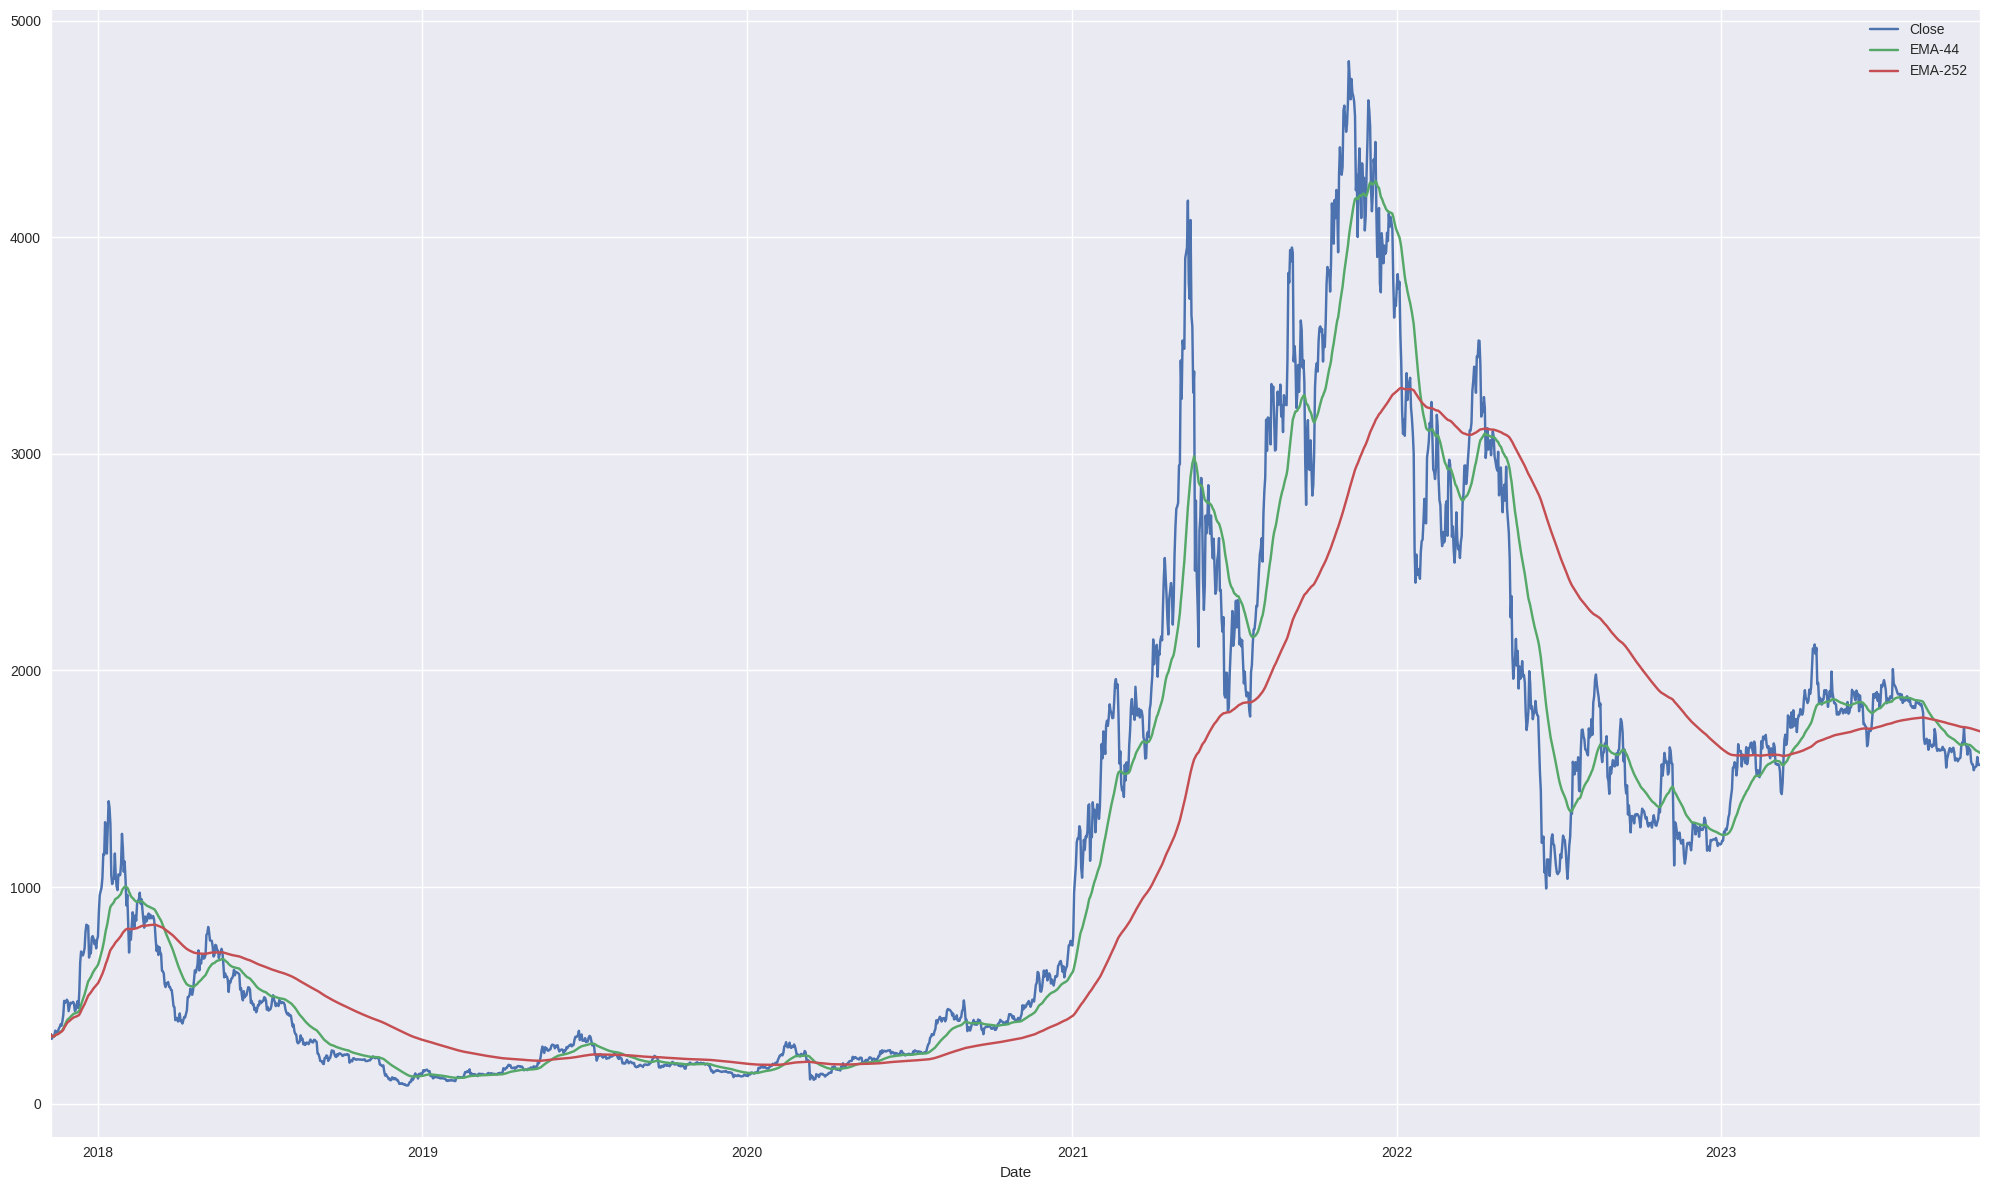

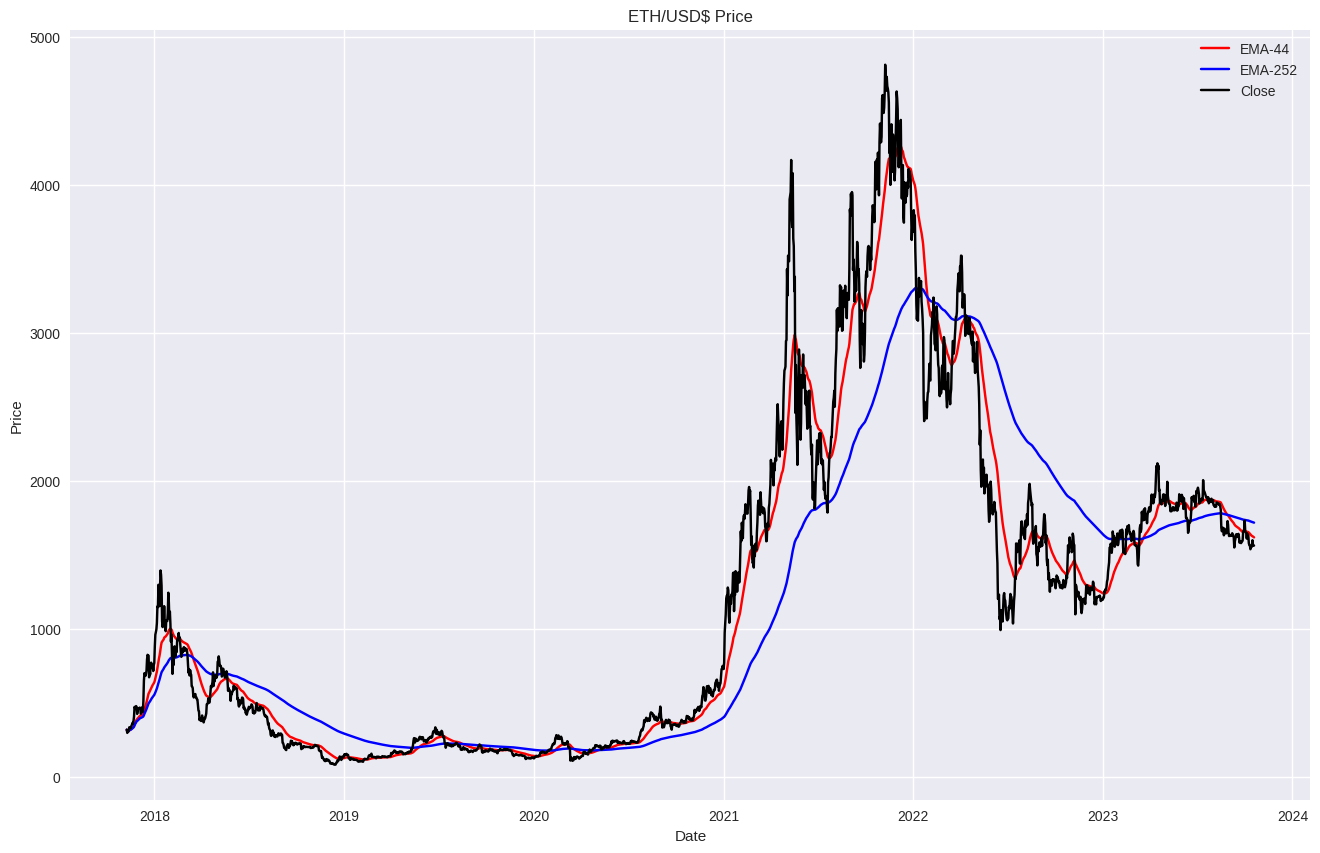

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family']

import yfinance as yf

eth = yf.Ticker("ETH-USD")
df_eth = yf.download(tickers="ETH-USD", period="max", interval="1d")

# Calculate EMAs (Exponential moving averages)
df_eth['EMA-44'] = df_eth['Close'].ewm(span=44).mean() # Calculates the values for the shorter EMA
df_eth['EMA-252'] = df_eth['Close'].ewm(span=252).mean() # Calculates the values for the longer EMA

# Drop unnecessary columns
df_eth_filtered = df_eth.drop(columns=['Open','High','Low','Adj Close','Volume'], axis=1)


import matplotlib.pyplot as plt

# Plot the filtered DataFrame
df_eth_filtered.plot( figsize=(20, 12))
plt.tight_layout()
# Show the plot
plt.show()

## Plot with Seaborn
import seaborn as sns

# Set the figure size
plt.figure(figsize=(16, 10))

# Plot the EMA lines
sns.lineplot(
    x="Date",
    y='EMA-44',
    data=df_eth_filtered,
    color='red',
    label='EMA-44'
)
sns.lineplot(
    x="Date",
    y='EMA-252',
    data=df_eth_filtered,
    color='blue',
    label='EMA-252'
)
sns.lineplot(
    x="Date",
    y='Close',
    data=df_eth_filtered,
    color='black',
    label='Close'
)
# Set the title and labels
plt.title("ETH/USD$ Price")
plt.xlabel("Date")
plt.ylabel("Price")

# Show the plot
plt.show()

## Plot with Plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Line(
    x=df_eth_filtered.index,
    y=df_eth_filtered['EMA-44'],
    name='EMA-44',
    marker_color='red'
))
fig.add_trace(go.Line(
    x=df_eth_filtered.index,
    y=df_eth_filtered['EMA-252'],
    name='EMA-252',
    marker_color='blue'
))

# Plot the Close line
fig.add_trace(go.Line(
    x=df_eth_filtered.index,
    y=df_eth_filtered['Close'],
    name='Close',
    marker_color='black'
))

# Set the title and labels
fig.update_layout(
    title="ETH/USD$ Price",
    xaxis_title="Date",
    yaxis_title="Price"
)

# Set the figure size
fig.update_layout(
    width=1200,
    height=800
)

# Show the plot
fig.show()

# Generating trading signals with moving average crossover

 Here we want to implements a simple trading strategy based on the Exponential moving average (EMA) to generate trading signals. The strategy works as follows:

Two EMAs with time periods of 44 and 252 days are calculated.
If the 44-day EMA is above the 252-day EMA, a long position is opened.
If the 44-day EMA is below the 252-day EMA, a short position is opened.
Output:

A plot of ETH price and the "Position" column is created.

- Input variables:

df_eth: A DataFrame containing ETH price data

- Output variables:

df_eth_filtered: A DataFrame containing ETH price data and the "Position" column

### Generating trading signals
Once the moving averages have been calculated, we can use them to generate trading signals. The strategy works by looking for the point at which the 44-day EMA crosses above or below the 252-day EMA.

In this case, a value of 1 indicates a long position, and a value of -1 indicates a short position.



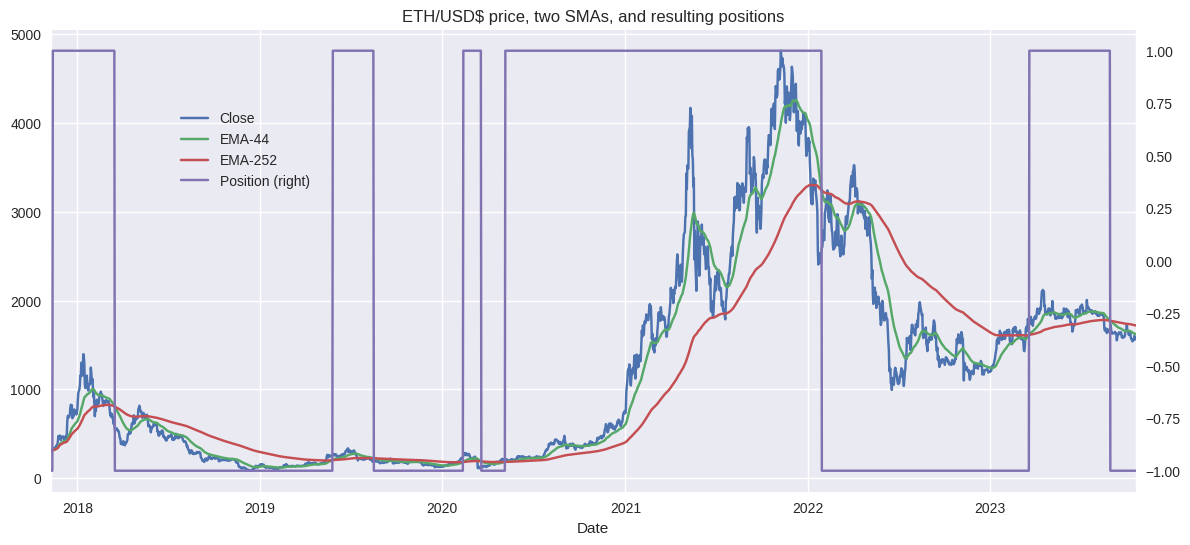

In [2]:
# Generate trading signals
df_eth_filtered['Position'] = np.where(df_eth_filtered['EMA-44'] > df_eth_filtered['EMA-252'], 1, -1)

import matplotlib.pyplot as plt

# Plot the results
fig, ax = plt.subplots(figsize=(14, 6))
df_eth_filtered.plot(ax=ax, secondary_y='Position')

# Set the title and labels
ax.set_title('ETH/USD$ price, two SMAs, and resulting positions')
ax.set_xlabel('Date')

# Adjust the legend position
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

# Show the plot
plt.show()

## Strategy Performance:
This Section analyzes the performance of an EMA-based trading strategy applied to ETH/USD prices. It calculates the daily logarithmic returns of the closing prices and uses a specified 'Position' value to generate strategy returns.

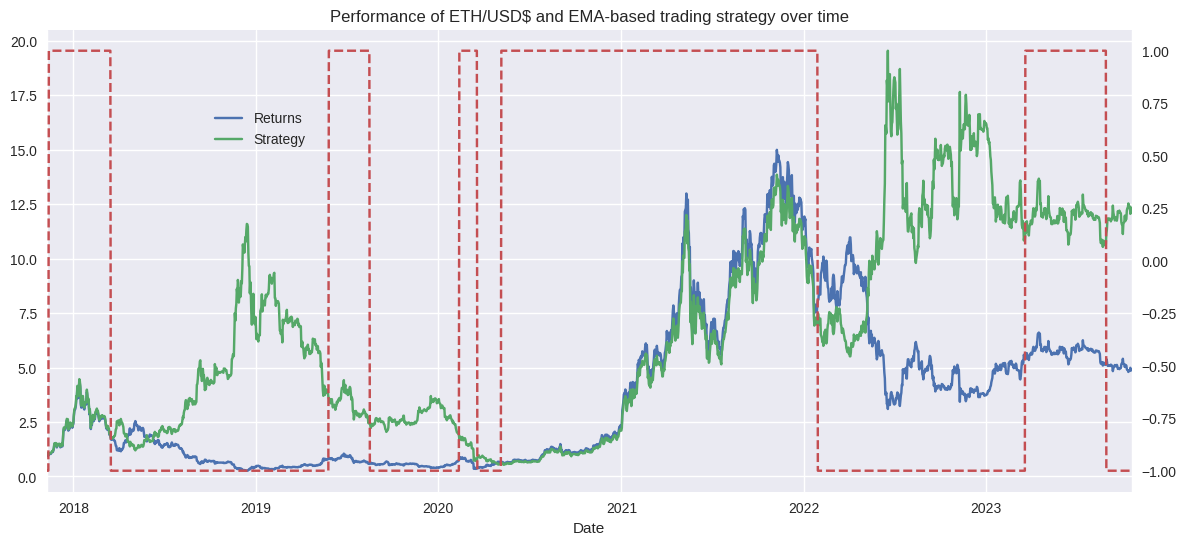

In [3]:
# Calculate the daily returns (returns of the price)
df_eth_filtered['Returns'] = np.log(df_eth_filtered['Close'] / df_eth_filtered['Close'].shift(1))

# Calculate the returns of the strategy
df_eth_filtered['Strategy'] = df_eth_filtered['Position'].shift(1) * df_eth_filtered['Returns']

# Calculate the total return of the strategy
np.exp(df_eth_filtered[['Returns', 'Strategy']].sum())

# Calculate the standard deviation of the strategy returns
df_eth_filtered[['Returns', 'Strategy']].std() * 252 ** 0.5

# Plot the cumulative returns of the strategy
ax = df_eth_filtered[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(14, 6))
df_eth_filtered['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
ax.set_title('Performance of ETH/USD$ and EMA-based trading strategy over time')
plt.show()

## Implementing two EMAs Crossover trading strategy Signals:
This code implements a trading strategy based on the comparison of two exponential moving averages (EMA-44 and EMA-252). It calculates the daily returns of ETH/USD prices and generates trading signals accordingly. The strategy returns and cumulative strategy returns are calculated and plotted. Additionally, the Sharpe Ratio is computed as a measure of risk-adjusted return.

in summary:

- This code defines two trading signals:
- Buy: EMA-44 > EMA-252
- Sell: EMA-44 < EMA
- calculates the daily returns of the ETH/USD price
- calculates the returns of the trading strategy
- calculates the cumulative returns of the trading strategy
- plot the cumulative returns of the trading strategy
- calculates the Sharpe Ratio of the trading strategy

The Sharpe Ratio is a measure of the risk-adjusted performance of an investment. It is calculated by dividing the average return of the investment by its standard deviation.

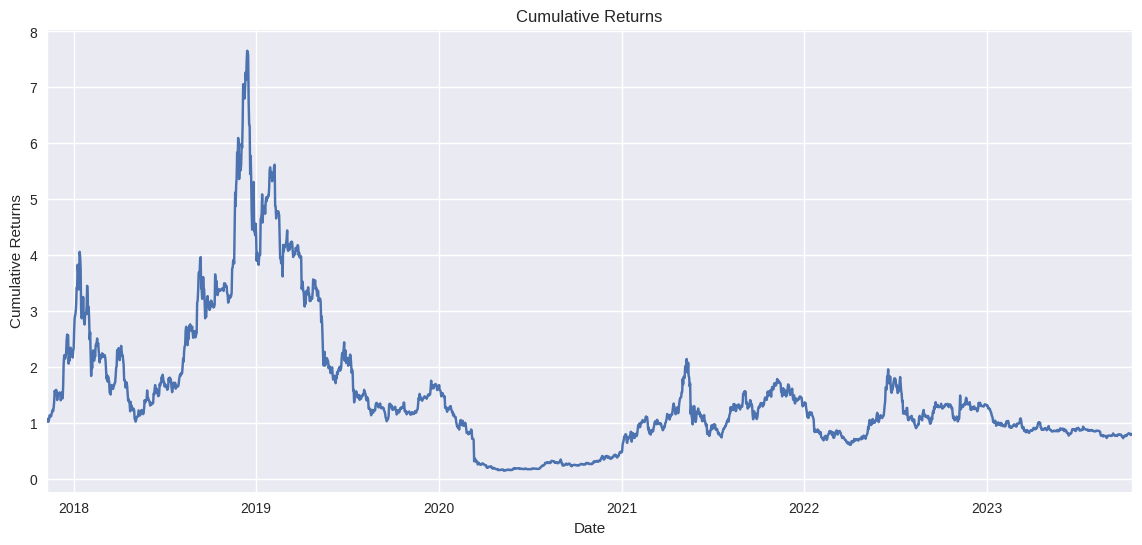

Sharpe Ratio: 0.3696797054997705


In [4]:
# Define trading signals
df_eth_filtered['Buy_Signal'] = (df_eth_filtered['EMA-44'] > df_eth_filtered['EMA-252'])
df_eth_filtered['Sell_Signal'] = (df_eth_filtered['EMA-44'] < df_eth_filtered['EMA-252'])

# Calculate returns (daily returns)
df_eth_filtered['Return'] = np.log(df_eth_filtered['Close'] / df_eth_filtered['Close'].shift(1))

# Calculate trading strategy returns
df_eth_filtered['Strategy_Return'] = df_eth_filtered['Return'] * df_eth_filtered['Buy_Signal'] - df_eth_filtered['Return'] * df_eth_filtered['Sell_Signal']

# Calculate cumulative returns of the trading strategy
df_eth_filtered['Cumulative_Strategy_Returns'] = (1 + df_eth_filtered['Strategy_Return']).cumprod()

# Plot cumulative returns of the trading strategy
import matplotlib.pyplot as plt

df_eth_filtered['Cumulative_Strategy_Returns'].plot(figsize=(14,6))
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate Sharpe Ratio of the trading strategy
sharpe_ratio = df_eth_filtered['Strategy_Return'].mean() / df_eth_filtered['Strategy_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

In [5]:
df_eth_filtered

,Close,EMA-44,EMA-252,Position,Returns,Strategy,Buy_Signal,Sell_Signal,Return,Strategy_Return,Cumulative_Strategy_Returns
Date,,,,,,,,,,,
2017-11-09,320.884003,320.884003,320.884003,-1,NaN,NaN,False,False,NaN,NaN,NaN
2017-11-10,299.252991,309.822690,310.025578,-1,-0.069790,0.069790,False,True,-0.069790,0.069790,1.069790
2017-11-11,314.681000,311.516282,311.589717,-1,0.050270,-0.050270,False,True,0.050270,-0.050270,1.016012
2017-11-12,307.907990,310.551794,310.658299,-1,-0.021758,0.021758,False,True,-0.021758,0.021758,1.038119
2017-11-13,316.716003,311.899199,311.889147,1,0.028204,-0.028204,True,False,0.028204,0.028204,1.067398
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,1558.069824,1629.157322,1724.009306,-1,0.001807,-0.001807,False,True,0.001807,-0.001807,0.803613
2023-10-16,1600.534302,1627.885187,1723.033219,-1,0.026890,-0.026890,False,True,0.026890,-0.026890,0.782004
2023-10-17,1565.439575,1625.109827,1721.787419,-1,-0.022171,0.022171,False,True,-0.022171,0.022171,0.799342


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_eth_filtered, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_eth_filtered, *['EMA-44'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_eth_filtered, *['EMA-252'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_eth_filtered, *['Position'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_eth_filtered, *['Buy_Signal'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_eth_filtered, *['Sell_Signal'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_eth_filtered, *['Close', 'EMA-44'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_eth_filtered, *['EMA-44', 'EMA-252'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_eth_filtered, *['EMA-252', 'Position'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_eth_filtered, *['Position', 'Returns'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_eth_filtered, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_eth_filtered, *['EMA-44'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_eth_filtered, *['EMA-252'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_eth_filtered, *['Position'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_eth_filtered, *['Buy_Signal', 'Sell_Signal'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_eth_filtered, *['Close', 'Buy_Signal'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_eth_filtered, *['Close', 'Sell_Signal'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_eth_filtered, *['EMA-44', 'Buy_Signal'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_eth_filtered, *['EMA-44', 'Sell_Signal'], **{'inner': 'box'})
chart

Reference of Presenting New Solution Design Section:

Book Name: Python for Finance: Mastering Data-Driven Finance 2nd Edition

Publisher: O'Reilly Media, Inc.

Author: Yves Hilpisch

Chapter: 15

Pages: 484-489

https://www.oreilly.com/library/view/python-for-finance/9781492024323/